## Housing Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation



### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')



In [5]:
# reading the training dataset
housing_train = pd.read_csv("train.csv", na_values='NaN')

In [6]:
housing_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [7]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
## To explore the Automated EDA, we can use the sweetbiz to perform EDA quickly

!pip install sweetviz

In [12]:
import sweetviz as sv

In [13]:
sweet_report = sv.analyze(housing_train, pairwise_analysis="off")

Feature: SalePrice                           |██| [100%]   00:08 -> (00:00 left)


In [14]:
sweet_report.show_html('sweet_report.html')

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### There are total 81 features. 54 categorical and 26 Numerical and 1 Text feature. Let us do Distribution plot for the Numerical feature and Box plot for the categorical features.

In [15]:
## In the sweetviz report, it clearly highlighted in red the feature with high missing value

<Axes: xlabel='SalePrice', ylabel='Density'>

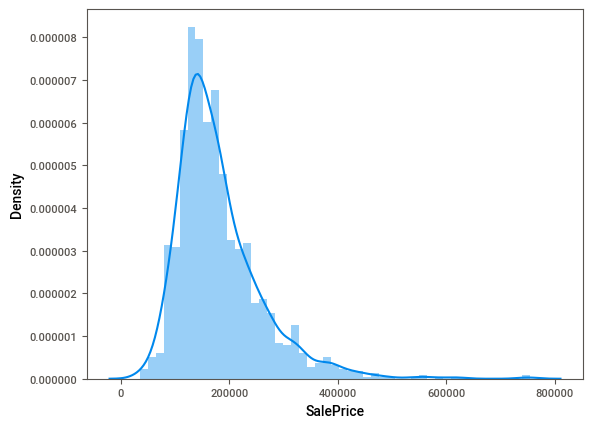

In [16]:
sns.distplot(housing_train.SalePrice)

In [19]:
## We can see the sale price is right skewed. Most of the houses are in the Low to Average sale price

In [20]:
# The NA values observed in certain features are not exactly the missing values instead it indicates a different category as 
# as defined in the data dictionary. For example NA in Pool_QC indicates No pool.

In [22]:
# Replace NaN values in the Pool_QC column with the value "No Pool"
housing_train['PoolQC'] = housing_train['PoolQC'].fillna('No Pool')

In [24]:
housing_train['Fence'] = housing_train['Fence'].fillna('No Fence')

In [25]:
housing_train['MiscFeature'] = housing_train['MiscFeature'].fillna('No Misc')

In [26]:
housing_train['FireplaceQu'] = housing_train['FireplaceQu'].fillna('No Fireplace')

In [27]:
housing_train['Alley'] = housing_train['Alley'].fillna('No Alleyaccess')

In [35]:
# Let us do the correlation matrix to identify the variables havign good relation with Sales price

# Take only the numerical variables

# all numeric (float and int) variables in the dataset
housing_numeric = housing_train.select_dtypes(include=['float64', 'int64'])
housing_numeric.head()

# correlation matrix
cor = housing_numeric.corr()
cor

Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
TotalBsmtSF   -0.015415   -0.238518     0.392075  0.260833     0.537808   
1stFlrSF       0.010496   -0.251758     0.457181  0.299475     0.476224   
2ndFlrSF       0.005590    0.307886     0.080177  0.050986     0.295493   
LowQualFinSF  -0.044230    0.046474     0.038469  0.004779    -0.030429   
GrLivArea      0.008273    0.074853     0.402797  0.263116     0.593007   
BsmtFullBath   0.002289    0.003491     0.100949  0.158155     0.111098   
BsmtHalfBath  -0.020155   -0.002333    -0.007234  0.048046    -0.040150   
FullBath       0.005587    0.131608     0.198769  0.126031     0.550600   
HalfBath       0.006784    0.177354     0.053532  0.014259     0.273458   
BedroomAbvGr   0.037719   -0.023438     0.263170  0.119690     0.101676   
KitchenAbvGr   0.002951    0.281721    -0.006069 -0.017784    -0.183882   
TotRmsAbvGrd   0.027239    0.040380     0.352096  0.190015     0.427452   
Fireplaces    -0.019772   -0.045569     0.266639  0.271364     0.396765   
GarageYrBlt    0.000072    0.085072     0.070250 -0.024947     0.547766   
GarageCars     0.016570   -0.040110     0.285691  0.154871     0.600671   
GarageArea     0.017634   -0.098672     0.344997  0.180403     0.562022   
WoodDeckSF    -0.029643   -0.012579     0.088521  0.171698     0.238923   
OpenPorchSF   -0.000477   -0.006100     0.151972  0.084774     0.308819   
EnclosedPorch  0.002889   -0.012037     0.010700 -0.018340    -0.113937   
3SsnPorch     -0.046635   -0.043825     0.070029  0.020423     0.030371   
ScreenPorch    0.001330   -0.026030     0.041383  0.043160     0.064886   
PoolArea       0.057044    0.008283     0.206167  0.077672     0.065166   
MiscVal       -0.006242   -0.007683     0.003368  0.038068    -0.031406   
MoSold         0.021172   -0.013585     0.011200  0.001205     0.070815   
YrSold         0.000712   -0.021407     0.007450 -0.014261    -0.027347   
SalePrice     -0.021917   -0.084284     0.351799  0.263843     0.790982   

               OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id                0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass       -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage      -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea          -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual      -0.091932   0.572323      0.550684    0.411876    0.239666   
OverallCond       1.000000  -0.375983      0.073741   -0.128101   -0.046231   
YearBuilt        -0.375983   1.000000      0.592855    0.315707    0.249503   
YearRemodAdd      0.073741   0.592855      1.000000    0.179618    0.128451   
MasVnrArea       -0.128101   0.315707      0.179618    1.000000    0.264736   
BsmtFinSF1       -0.046231   0.249503      0.128451    0.264736    1.000000   
BsmtFinSF2        0.040229  -0.049107     -0.067759   -0.072319   -0.050117   
BsmtUnfSF        -0.136841   0.149040      0.181133    0.114442   -0.495251   
TotalBsmtSF      -0.171098   0.391452      0.291066    0.363936    0

In [37]:
# let us review and remove the unwanted column for analysis 

# Dropping "Id" column as it is not needed, Also the year column

housing_numeric.drop(columns="Id", inplace=True)


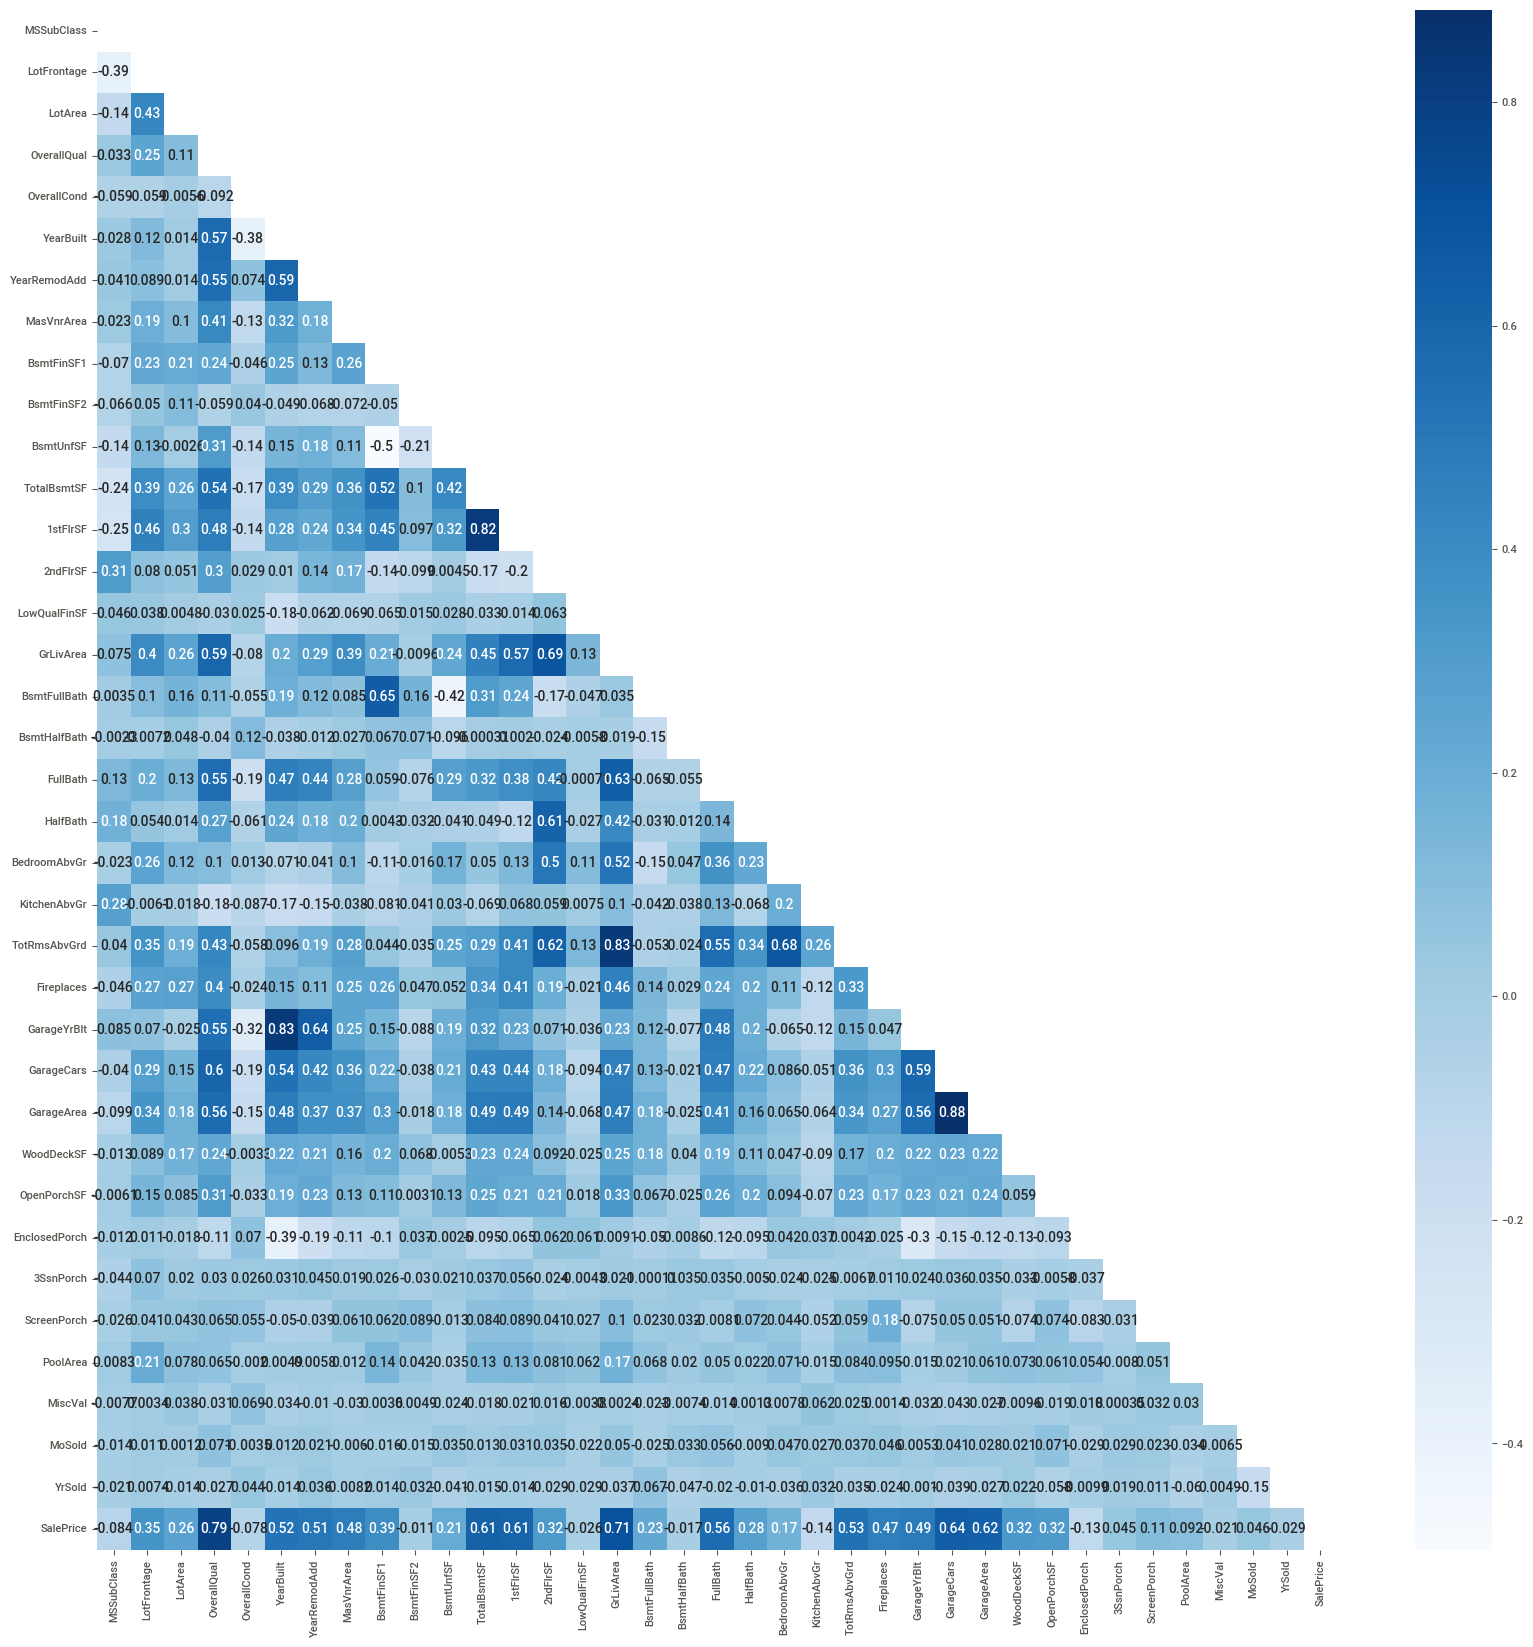

In [45]:
## Plotting heatmap to check the corellation between varables

plt.figure(figsize = (20, 20))
corr_mat = np.triu(housing_numeric.corr())
sns.heatmap(housing_numeric.corr(), annot = True, cmap="Blues", mask=corr_mat)
plt.show()

#### let us list some of the feature with less correlation with Sale price 

MSSubClass
OverallCond
BsmtFinSF2
LowQualFinSF
BsmtHalfBath
KitchenAbvGr
EnclosedPorch
MiscVal
MoSold
YrSold

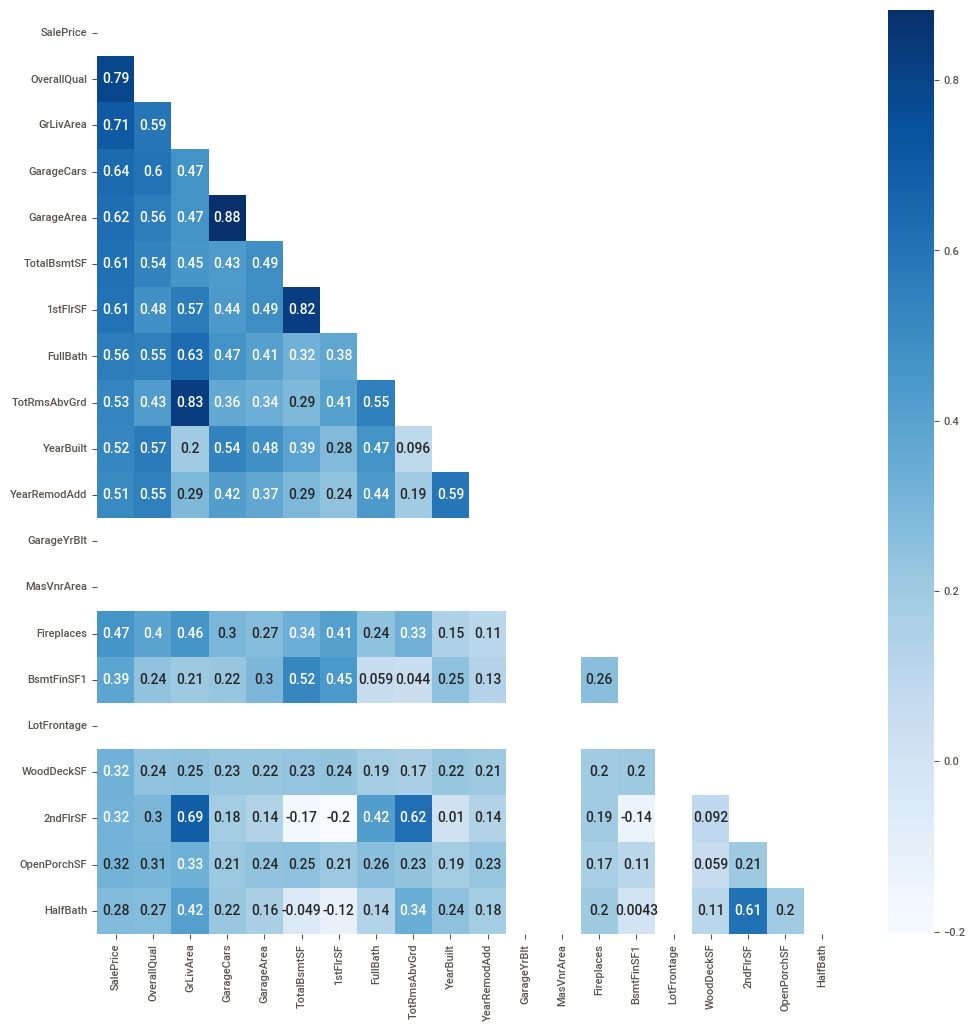

In [46]:
#Let us do correlation matrix heatmap for the top 20 correlated features

k = 20 #number of variables for heatmap
plt.figure(figsize=(12,12))
columns = housing_numeric.corr().nlargest(k, 'SalePrice')['SalePrice'].index
corr_mat = np.triu(columns)
cm = np.corrcoef(housing_numeric[columns].values.T)
hm = sns.heatmap(cm, cmap="Blues", cbar=True, annot=True, xticklabels=columns.values, yticklabels=columns.values, mask=corr_mat)
plt.show()

In [47]:
# REplace NUll values in the numerical variable with its median value

# Numeric
housing_numeric["LotFrontage"].fillna(housing_numeric["LotFrontage"].median(), inplace=True)
housing_numeric["GarageYrBlt"].fillna(housing_numeric["GarageYrBlt"].median(), inplace=True)
housing_numeric["MasVnrArea"].fillna(housing_numeric["MasVnrArea"].median(), inplace=True)


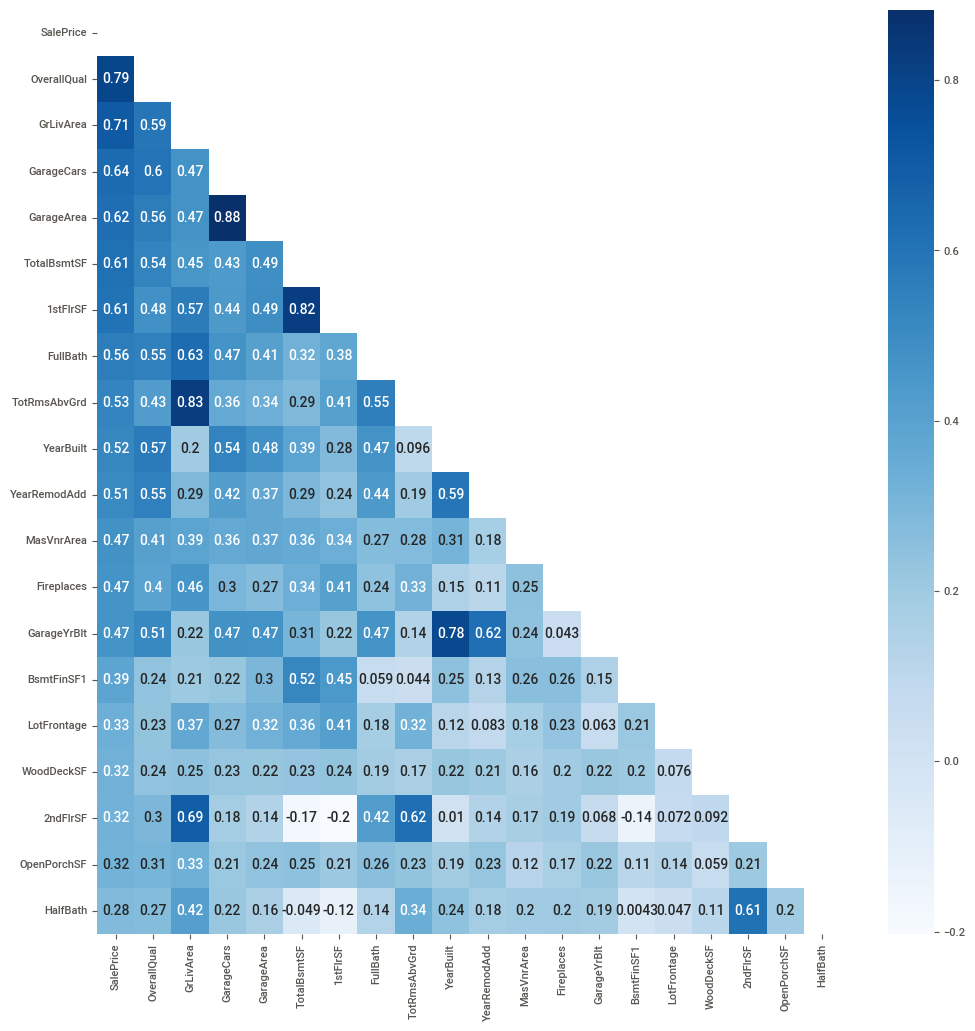

In [48]:
k = 20 #number of variables for heatmap
plt.figure(figsize=(12,12))
columns = housing_numeric.corr().nlargest(k, 'SalePrice')['SalePrice'].index
corr_mat = np.triu(columns)
cm = np.corrcoef(housing_numeric[columns].values.T)
hm = sns.heatmap(cm, cmap="Blues", cbar=True, annot=True, xticklabels=columns.values, yticklabels=columns.values, mask=corr_mat)
plt.show()

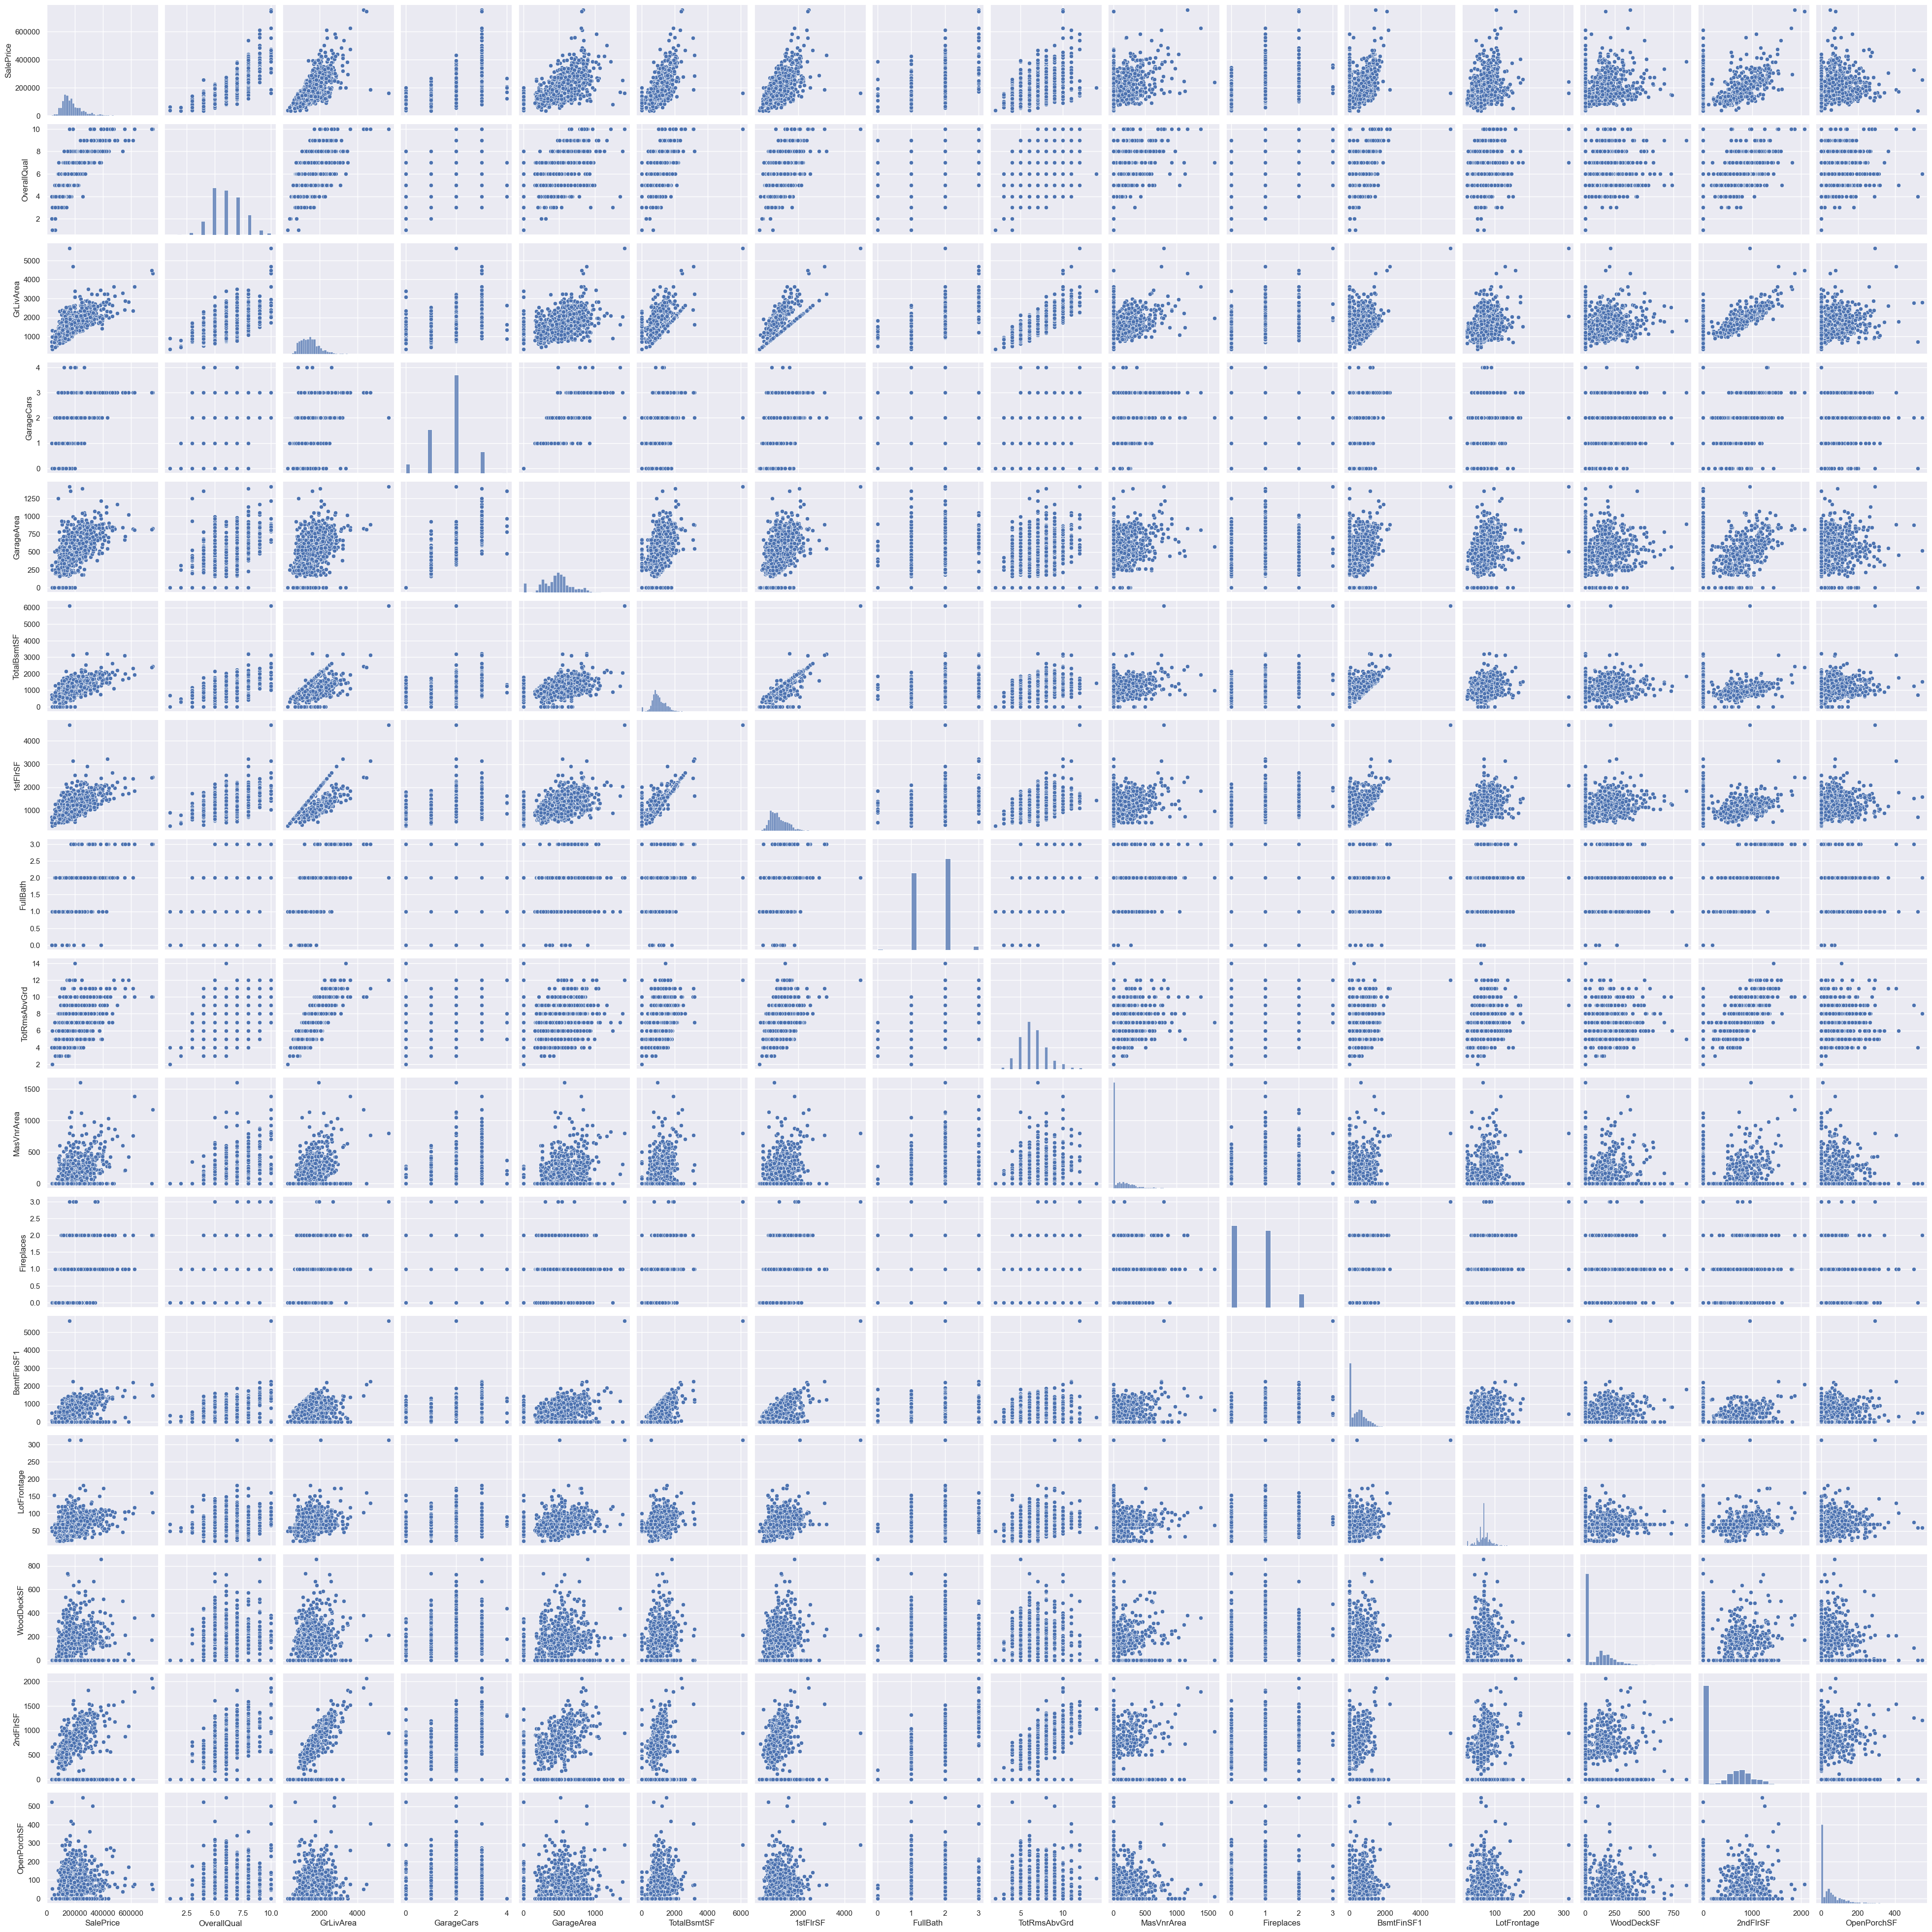

In [52]:
# Perform Scatter Plot to understand the correlation further (ignoring years)

sns.set()
columns = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 
           'FullBath','TotRmsAbvGrd', 'MasVnrArea','Fireplaces', 'BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF']#
sns.pairplot(housing_numeric[columns])
#plt.show();

In [53]:
plt.show()

In [55]:
housing_categorical = housing_train.select_dtypes(include=['object'])

In [58]:
categorical_columns = housing_categorical.columns

In [59]:
categorical_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [61]:
for c in categorical_columns:
    print (f"{c} has number of categories : {housing_categorical[c].unique()}")
    print (f"{housing_categorical[c].value_counts()}\n")

MSZoning has number of categories : ['RL' 'RM' 'C (all)' 'FV' 'RH']
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Street has number of categories : ['Pave' 'Grvl']
Pave    1454
Grvl       6
Name: Street, dtype: int64

Alley has number of categories : ['No Alleyaccess' 'Grvl' 'Pave']
No Alleyaccess    1369
Grvl                50
Pave                41
Name: Alley, dtype: int64

LotShape has number of categories : ['Reg' 'IR1' 'IR2' 'IR3']
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

LandContour has number of categories : ['Lvl' 'Bnk' 'Low' 'HLS']
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Utilities has number of categories : ['AllPub' 'NoSeWa']
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

LotConfig has number of categories : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3          

In [62]:
#List of categorical columns that are highly skewed

# PoolQC, GarageCond, GarageQual, CentralAir, Electrical, Heating, BsmtFinType2, BsmtCond, ExterCond, RoofMatl
# RoofStyle, Condition2, Condition1, LandSlope, Utilities, Alley, Street

In [64]:
housing_categorical.drop(columns=['PoolQC', 'GarageCond', 'GarageQual', 'CentralAir', 'Electrical', 'Heating', 
                                  'BsmtFinType2', 'BsmtCond', 'ExterCond', 'RoofMatl','RoofStyle', 'Condition2',
                                  'Condition1', 'LandSlope', 'Utilities', 'Alley', 'Street'],inplace=True)

In [66]:
housing_categorical.shape

(1460, 26)

In [74]:
housing_categorical.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [71]:
#Similary perform the same for Numerical variable, using pivot table in the excel sheet and drop the below columns

housing_numeric.drop(columns=["LowQualFinSF", "BsmtHalfBath", "KitchenAbvGr", "3SsnPorch", "ScreenPorch", "PoolArea",
                     "MiscVal"], inplace=True)



In [73]:
housing_numeric.shape

(1460, 30)

#### Visualising Categorical Variables
As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

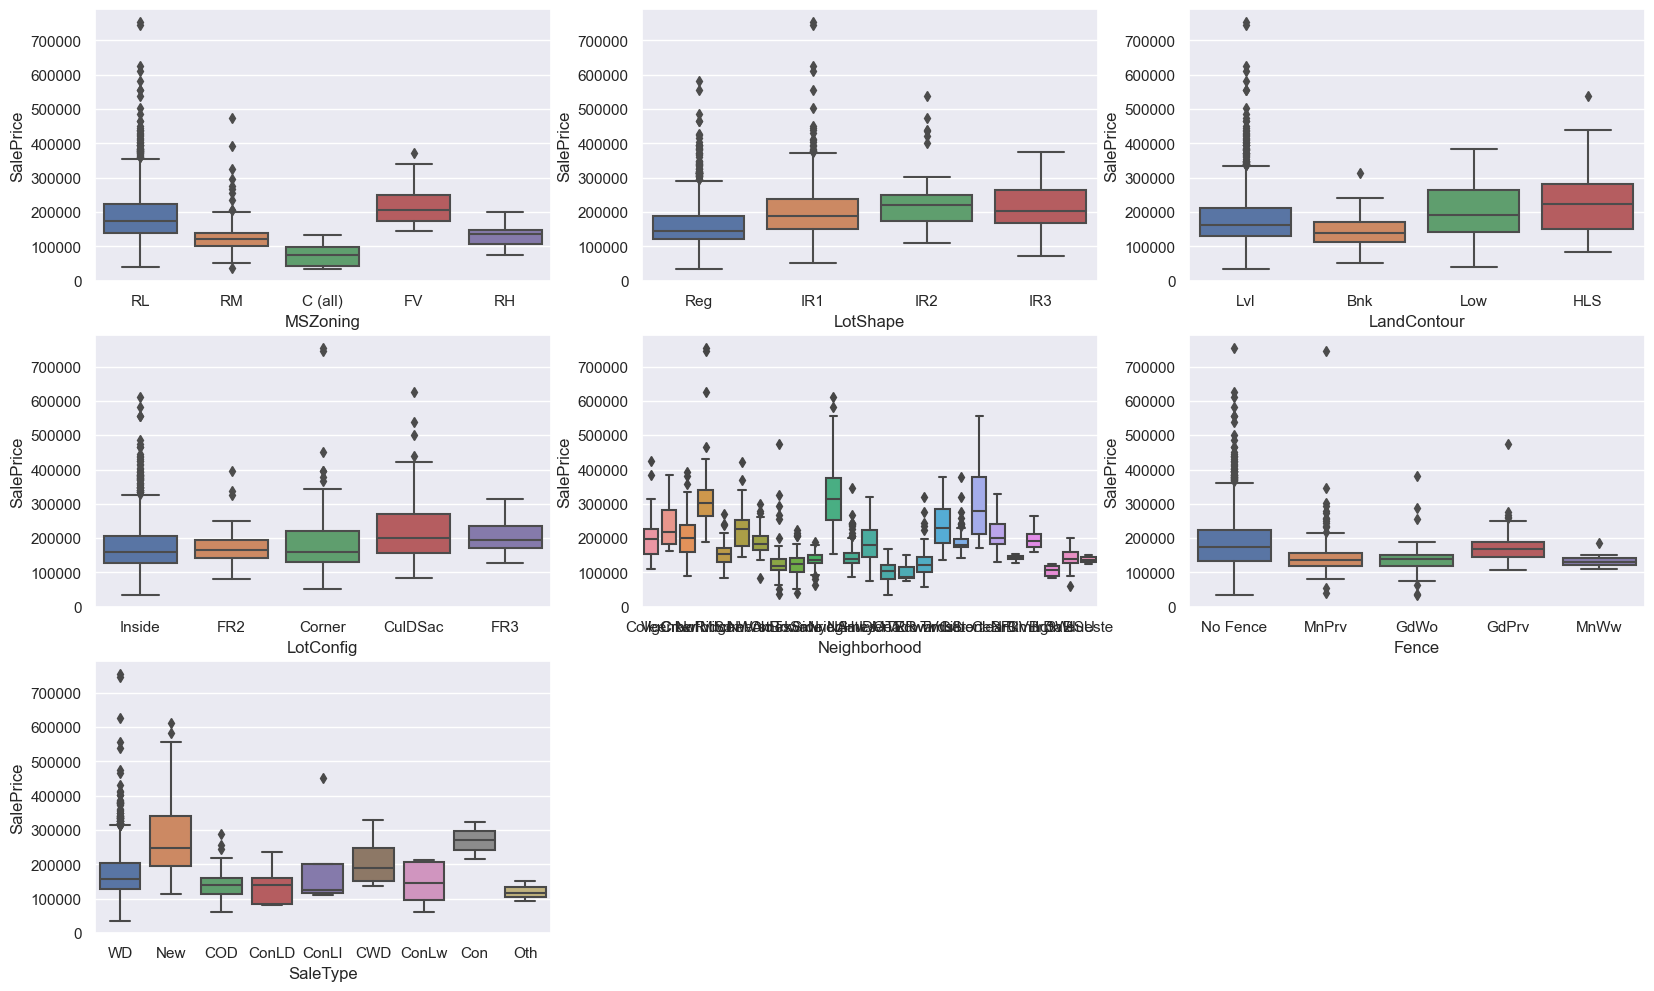

In [76]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,2)
sns.boxplot(x = 'LotShape', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,3)
sns.boxplot(x = 'LandContour', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,4)
sns.boxplot(x = 'LotConfig', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,5)
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,6)
sns.boxplot(x = 'Fence', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,7)
sns.boxplot(x = 'SaleType', y = 'SalePrice', data = housing_train)
plt.show()

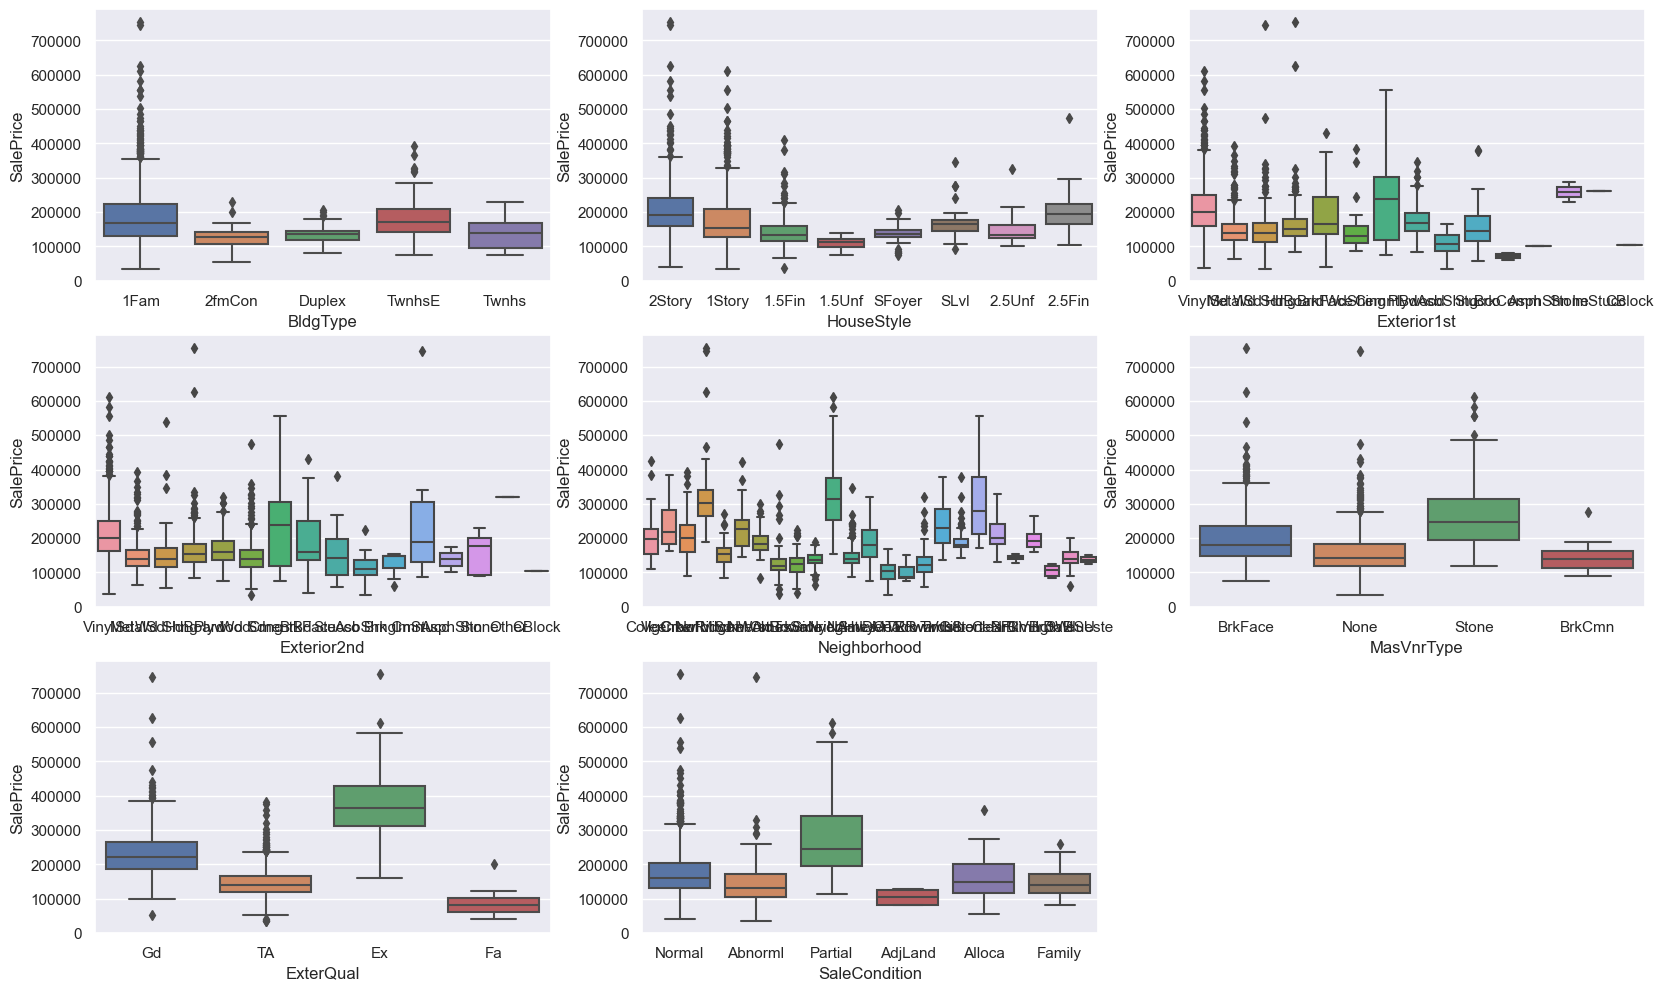

In [89]:


plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,2)
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,3)
sns.boxplot(x = 'Exterior1st', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,4)
sns.boxplot(x = 'Exterior2nd', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,5)
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,6)
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,7)
sns.boxplot(x = 'ExterQual', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,8)
sns.boxplot(x = 'SaleCondition', y = 'SalePrice', data = housing_train)
plt.show()

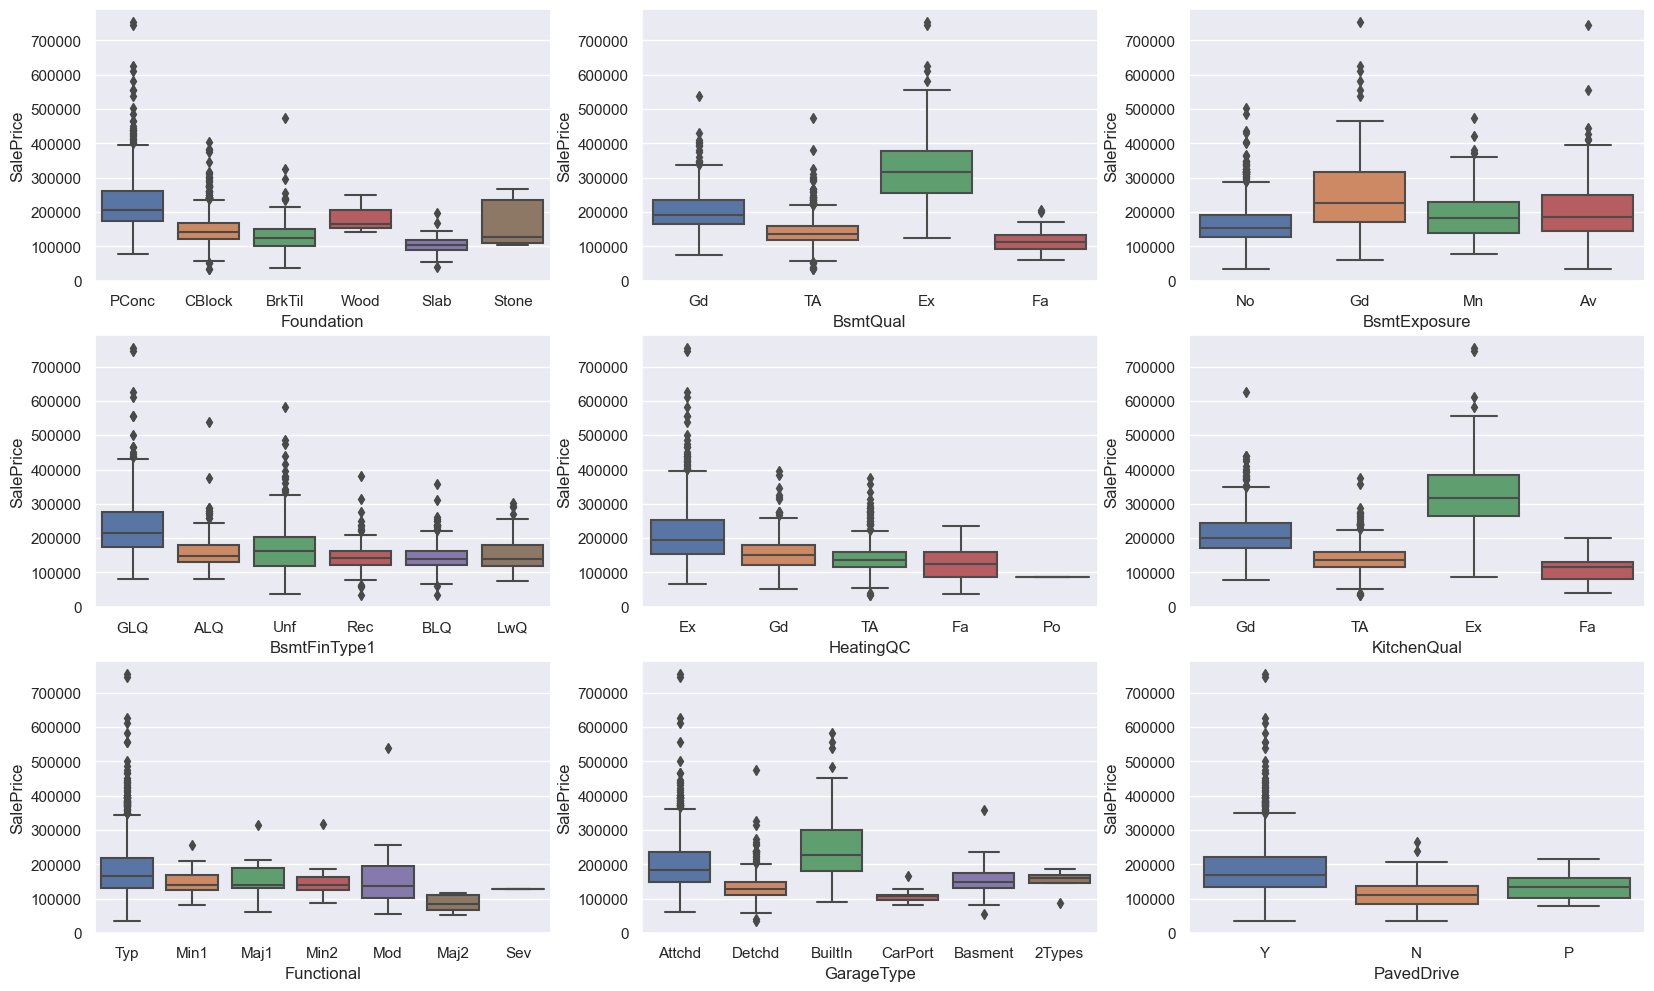

In [88]:

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'Foundation', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,2)
sns.boxplot(x = 'BsmtQual', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,3)
sns.boxplot(x = 'BsmtExposure', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,4)
sns.boxplot(x = 'BsmtFinType1', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,5)
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,6)
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,7)
sns.boxplot(x = 'Functional', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,8)
sns.boxplot(x = 'GarageType', y = 'SalePrice', data = housing_train)
plt.subplot(3,3,9)
sns.boxplot(x = 'PavedDrive', y = 'SalePrice', data = housing_train)
plt.show()

##  Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [ ]:

# Create dummy variables and drop original columns 
dummy_categorical_columns = pd.get_dummies(housing[unprocessed_categorical_columns_list], drop_first=True)